In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sps
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics

from surprise import (
    BaselineOnly,
    KNNBasic,
    KNNWithMeans,
    KNNBaseline,
    SVD,
    SVDpp,
    NMF,
    SlopeOne,
    CoClustering,
)
from surprise.model_selection import cross_validate
from surprise import Dataset, Reader
import myfm

plt.style.use("ggplot")
image_path = "images/"

# Data exploration


## New Movielens-100k


In [4]:
data_path = "ml-latest-small/"
df_rating = pd.read_csv(f"{data_path}ratings.csv")
df_rating

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
sparsity = 1 - len(df_rating) / (
    df_rating["movieId"].unique().shape[0] * df_rating["userId"].unique().shape[0]
)
print(f"sparsity: {sparsity:.4%}")
df_rating

sparsity: 98.3000%


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Distribution of Ratings


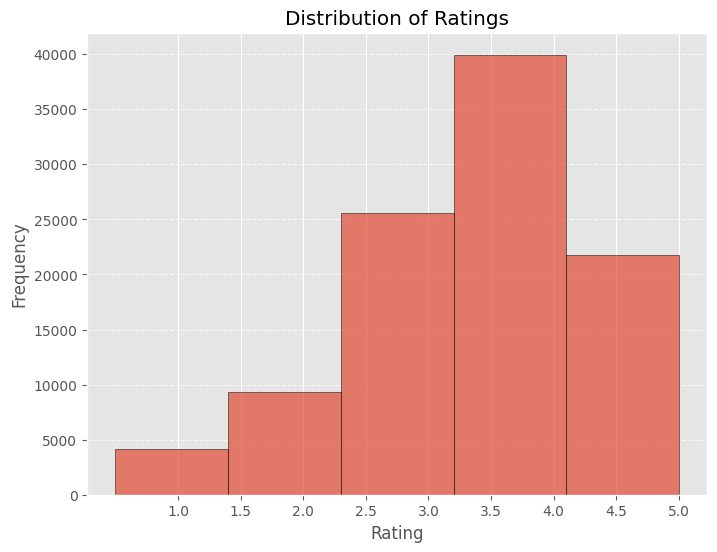

In [ ]:
# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(df_rating["rating"], bins=5, edgecolor="black", alpha=0.7)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Distribution of Ratings per movie/user


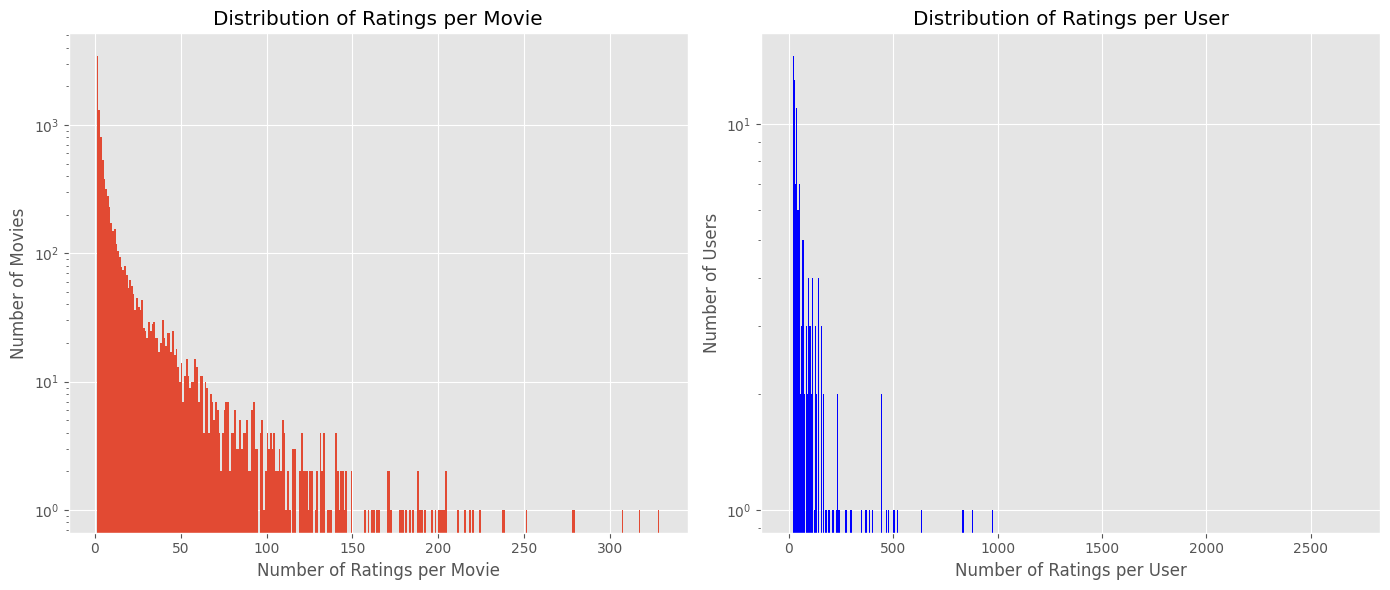

In [ ]:
rating_count = df_rating["movieId"].value_counts()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(rating_count, bins=range(1, rating_count.max() + 1), log=True)
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Number of Movies")
plt.title("Distribution of Ratings per Movie")
plt.grid(True)

user_rating_count = df_rating["userId"].value_counts()
plt.subplot(1, 2, 2)
plt.hist(
    user_rating_count,
    bins=range(1, user_rating_count.max() + 1),
    log=True,
    color="blue",
)
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")
plt.title("Distribution of Ratings per User")
plt.grid(True)
plt.tight_layout()
plt.show()

### Additional metadata


In [6]:
df_movie = pd.read_csv(f"{data_path}movies.csv")
df_movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [7]:
df_movie["release_year"] = df_movie["title"].str.extract(r"\((\d{4})\)")
df_movie["title"] = df_movie["title"].str.replace(r"\s*\(\d{4}\)$", "", regex=True)
df_movie["release_year"] = df_movie["release_year"].astype(str)
print(df_movie["release_year"].isnull().sum())
df_movie

0


,movieId,title,genres,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017
9739,193585,Flint,Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018


In [ ]:
df_tag = pd.read_csv(f"{data_path}tags.csv")
df_tag

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [26]:
df_link = pd.read_csv(f"{data_path}links.csv")
df_link

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


# Recommender System Model


## Pure Collaborative Filtering (No extra metadata)


In [21]:
# Load movielens-100k dataset
reader = Reader()
data = Dataset.load_from_df(df_rating[["userId", "movieId", "rating"]], reader)

# List of algorithms to test
algorithms = [
    BaselineOnly(),
    KNNBasic(),
    KNNWithMeans(),
    KNNBaseline(),
    SVD(),
    SVDpp(),
    NMF(),
    SlopeOne(),
    CoClustering(),
]

algo_names = [
    "BaselineOnly",
    "KNNBasic",
    "KNNWithMeans",
    "KNNBaseline",
    "SVD",
    "SVDpp",
    "NMF",
    "SlopeOne",
    "CoClustering",
]

# Dictionary to store results
results = {}

# Run cross-validation for each algorithm
for algo, name in zip(algorithms, algo_names):
    cv_results = cross_validate(
        algo, data, measures=["rmse", "mae"], cv=5, verbose=False
    )
    results[name] = {
        "RMSE": np.mean(cv_results["test_rmse"]),
        "MAE": np.mean(cv_results["test_mae"]),
    }

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating 

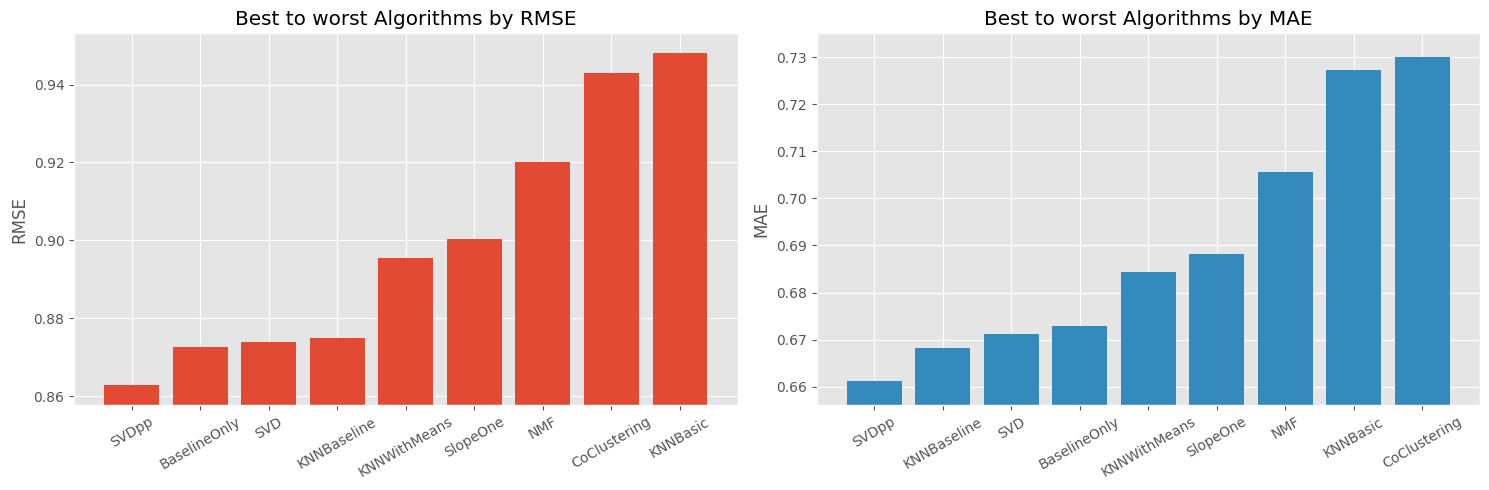

{'BaselineOnly': {'RMSE': 0.8724920183317781, 'MAE': 0.6728003991192218},
 'KNNBasic': {'RMSE': 0.9481740258445395, 'MAE': 0.7272079353654555},
 'KNNWithMeans': {'RMSE': 0.8955956496795819, 'MAE': 0.6844340646070446},
 'KNNBaseline': {'RMSE': 0.8748540091012403, 'MAE': 0.6683146170335565},
 'SVD': {'RMSE': 0.8737709758144181, 'MAE': 0.6711812673921982},
 'SVDpp': {'RMSE': 0.8627264328323765, 'MAE': 0.6611232242151358},
 'NMF': {'RMSE': 0.9200315476119151, 'MAE': 0.705533775296874},
 'SlopeOne': {'RMSE': 0.9003782381054389, 'MAE': 0.6882258082668695},
 'CoClustering': {'RMSE': 0.9430172286942792, 'MAE': 0.7300473908109396}}

In [22]:
algo_names = [
    "BaselineOnly",
    "KNNBasic",
    "KNNWithMeans",
    "KNNBaseline",
    "SVD",
    "SVDpp",
    "NMF",
    "SlopeOne",
    "CoClustering",
]
rmse_scores = np.array([results[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results[name]["MAE"] for name in algo_names])

# Order algorithms independently
order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)
# Create ordered lists for each metric
algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

# Create x-axis indices
x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot RMSE on the left, ordered by RMSE
ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst Algorithms by RMSE")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=30)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

# Plot MAE on the right, ordered by MAE
ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst Algorithms by MAE")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=30)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.savefig(f"{image_path}surpise_algo_comparison.png", dpi=300)
plt.show()
results

In [ ]:
df_train, df_test = train_test_split(df_rating, test_size=0.2, random_state=42)

def get_extended_features(
    X_train_base,
    X_test_base,
    df_train,
    df_test,
    incluse_variance=False,
    include_release_year=False,
    include_genres=False,
):
    X_train_ext = X_train_base
    X_test_ext = X_test_base
    group_shapes = None

    if incluse_variance:
        group_shapes = [len(group) for group in ohe.categories_]

    if include_release_year:
        X_train_release = movie_info_ohe.transform(
            movie_info.reindex(df_train.movieId).drop(columns=["genres"])
        )
        X_test_release = movie_info_ohe.transform(
            movie_info.reindex(df_test.movieId).drop(columns=["genres"])
        )
        X_train_ext = sps.hstack([X_train_ext, X_train_release])
        X_test_ext = sps.hstack([X_test_ext, X_test_release])
        group_shapes.extend([len(group) for group in movie_info_ohe.categories_])

    if include_genres:
        X_train_genres = movie_genre_mle.transform(
            movie_info.genres.reindex(df_train.movieId).apply(lambda x: x.split("|"))
        )
        X_test_genres = movie_genre_mle.transform(
            movie_info.genres.reindex(df_test.movieId).apply(lambda x: x.split("|"))
        )
        X_train_ext = sps.hstack([X_train_ext, X_train_genres])
        X_test_ext = sps.hstack([X_test_ext, X_test_genres])
        group_shapes.append(len(movie_genre_mle.classes_))

    return X_train_ext, X_test_ext, group_shapes


def train_predict_fm(
    df,
    include_variance=False,
    include_release_year=False,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []
    mae_scores = []

    for train_index, test_index in kf.split(df):
        df_train, df_test = df.iloc[train_index], df.iloc[test_index]

        X_train_base = ohe.transform(df_train[FEATURE_COLUMNS])
        X_test_base = ohe.transform(df_test[FEATURE_COLUMNS])
        y_train = df_train.rating.values
        y_test = df_test.rating.values

        X_train_ext, X_test_ext, group_shapes = get_extended_features(
            X_train_base,
            X_test_base,
            df_train,
            df_test,
            incluse_variance=include_variance,
            include_release_year=include_release_year,
            include_genres=include_genres,
        )

        model = myfm.MyFMRegressor(rank=fm_rank, random_seed=42)
        model.fit(
            X_train_ext,
            y_train,
            n_iter=200,
            n_kept_samples=200,
            group_shapes=group_shapes,
        )
        prediction = model.predict(X_test_ext)
        rmse = np.sqrt(((y_test - prediction) ** 2).mean())
        mae = np.abs(y_test - prediction).mean()

        rmse_scores.append(rmse)
        mae_scores.append(mae)

    mean_rmse = np.mean(rmse_scores)
    mean_mae = np.mean(mae_scores)

    return mean_rmse, mean_mae


# Usage example
FEATURE_COLUMNS = ["userId", "movieId"]
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(df_rating[FEATURE_COLUMNS])

movie_info = df_movie.set_index("movieId")[["release_year", "genres"]]
movie_info_ohe = OneHotEncoder(handle_unknown="ignore").fit(
    movie_info[["release_year"]]
)
movie_genre_mle = MultiLabelBinarizer(sparse_output=True).fit(
    movie_info.genres.apply(lambda x: x.split("|"))
)

alpha = 1.83 w0 = 3.35 : 100%|██████████| 200/200 [00:04<00:00, 44.82it/s]


(0.8529920798054922, 0.6552049988447564)

In [13]:
results_with_metadata = {}

output = train_predict_fm(
    df=df_rating,
    include_variance=False,
    include_release_year=False,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["baseline"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=False,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["variance"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=True,
    include_genres=False,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["variance/releaseYear"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=False,
    include_genres=True,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["variance/genres"] = {"RMSE": output[0], "MAE": output[1]}

output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=True,
    include_genres=True,
    fm_rank=10,
    n_splits=5,
)
results_with_metadata["everything"] = {"RMSE": output[0], "MAE": output[1]}

results_with_metadata

alpha = 2.31 w0 = 3.54 : 100%|██████████| 200/200 [00:10<00:00, 18.53it/s]


{'baseline': {'RMSE': 0.8529920798054922, 'MAE': 0.6552049988447564},
 'variance': {'RMSE': 0.8337999971010254, 'MAE': 0.6373708455231607},
 'variance/releaseYear': {'RMSE': 0.8241096632459695,
  'MAE': 0.6300280432952035},
 'variance/genres': {'RMSE': 0.8160679000134117, 'MAE': 0.624166666029912},
 'everything': {'RMSE': 0.8095809220972164, 'MAE': 0.6184699992220903}}

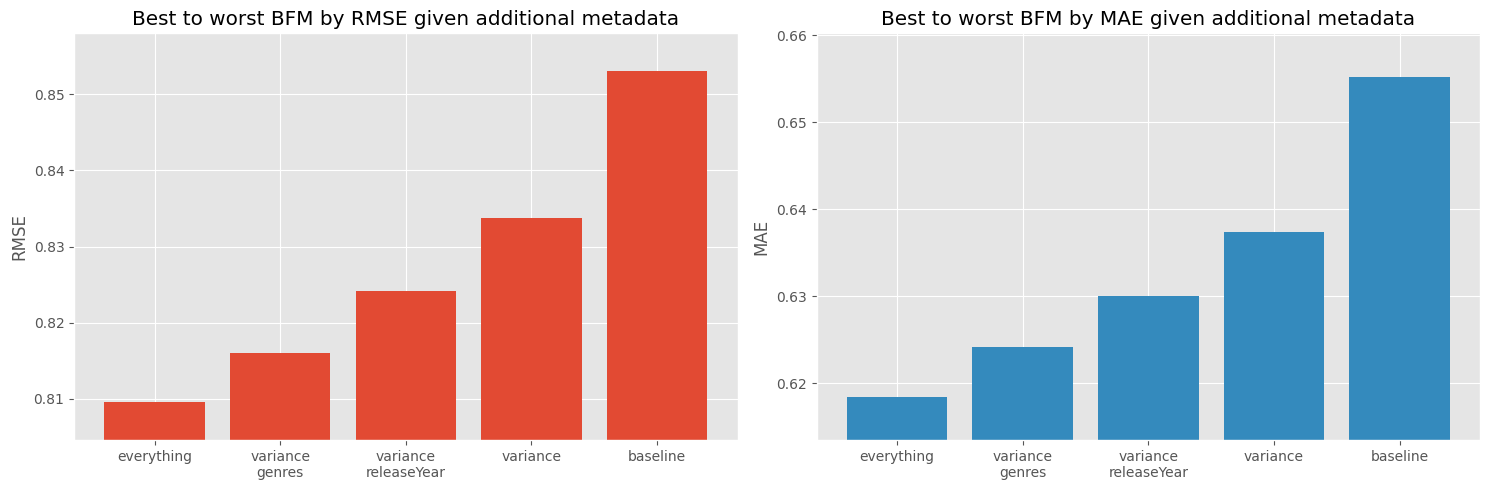

{'baseline': {'RMSE': 0.8529920798054922, 'MAE': 0.6552049988447564},
 'variance': {'RMSE': 0.8337999971010254, 'MAE': 0.6373708455231607},
 'variance/releaseYear': {'RMSE': 0.8241096632459695,
  'MAE': 0.6300280432952035},
 'variance/genres': {'RMSE': 0.8160679000134117, 'MAE': 0.624166666029912},
 'everything': {'RMSE': 0.8095809220972164, 'MAE': 0.6184699992220903}}

In [14]:
algo_names = [
    "baseline",
    "variance",
    "variance/releaseYear",
    "variance/genres",
    "everything",
]
rmse_scores = np.array([results_with_metadata[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results_with_metadata[name]["MAE"] for name in algo_names])

order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)

algo_names_rmse = [algo_names[i].replace("/", "\n") for i in order_rmse]
algo_names_mae = [algo_names[i].replace("/", "\n") for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst BFM by RMSE given additional metadata")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=0)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst BFM by MAE given additional metadata")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=0)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.savefig(f"{image_path}bfm_metadata_comparison.png", dpi=300)
plt.show()
results_with_metadata

In [17]:
results_with_FM = {}

for fm_rank in [10, 15, 20, 25, 30, 35, 40]:
    output = train_predict_fm(
        df=df_rating,
        include_variance=True,
        include_release_year=True,
        include_genres=True,
        fm_rank=fm_rank,
        n_splits=5,
    )
    results_with_FM[f"{fm_rank}"] = {"RMSE": output[0], "MAE": output[1]}

results_with_FM

alpha = 3.15 w0 = 3.58 : 100%|██████████| 200/200 [00:40<00:00,  4.94it/s]


{'10': {'RMSE': 0.8095809220972164, 'MAE': 0.6184699992220903},
 '15': {'RMSE': 0.8078713046385703, 'MAE': 0.6171318072640773},
 '20': {'RMSE': 0.8067885988048065, 'MAE': 0.6163814903008937},
 '25': {'RMSE': 0.807556169205054, 'MAE': 0.6165670606260625},
 '30': {'RMSE': 0.8076044236135693, 'MAE': 0.6169995064451081},
 '35': {'RMSE': 0.8075236626964785, 'MAE': 0.6168251377452408},
 '40': {'RMSE': 0.8077819685049361, 'MAE': 0.6169657037629094}}

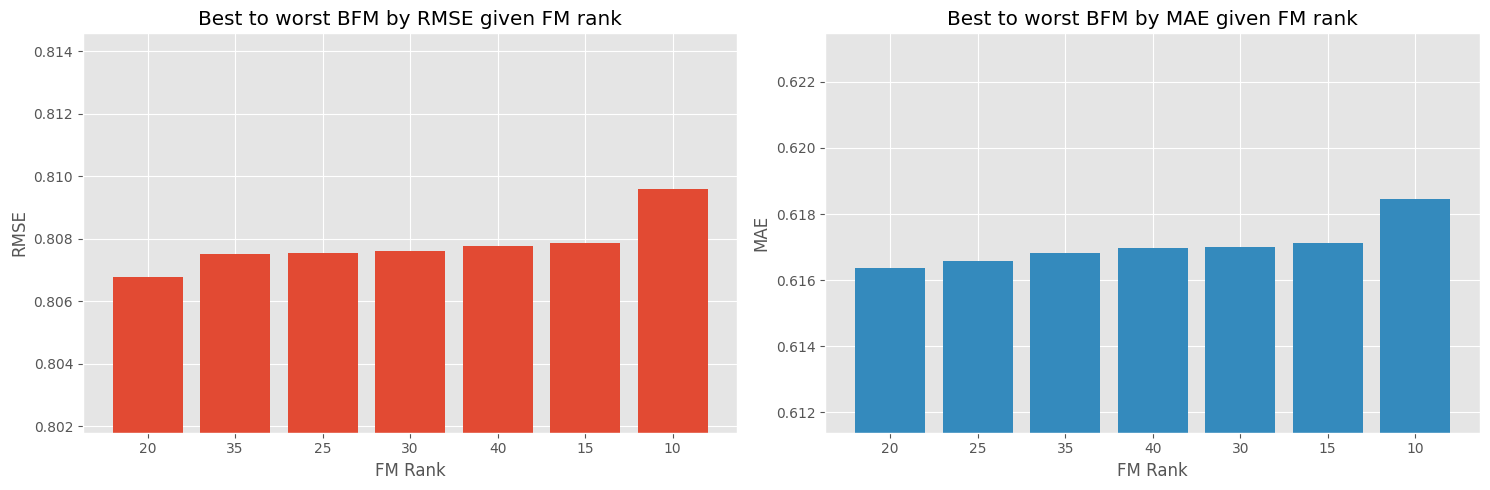

{'baseline': {'RMSE': 0.8529920798054922, 'MAE': 0.6552049988447564},
 'variance': {'RMSE': 0.8337999971010254, 'MAE': 0.6373708455231607},
 'variance/releaseYear': {'RMSE': 0.8241096632459695,
  'MAE': 0.6300280432952035},
 'variance/genres': {'RMSE': 0.8160679000134117, 'MAE': 0.624166666029912},
 'everything': {'RMSE': 0.8095809220972164, 'MAE': 0.6184699992220903}}

In [18]:
algo_names = ["10", "15", "20", "25", "30", "35", "40"]
rmse_scores = np.array([results_with_FM[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results_with_FM[name]["MAE"] for name in algo_names])

order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)

algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst BFM by RMSE given FM rank")
ax1.set_ylabel("RMSE")
ax1.set_xlabel("FM Rank")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=0)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst BFM by MAE given FM rank")
ax2.set_ylabel("MAE")
ax2.set_xlabel("FM Rank")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=0)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.savefig(f"{image_path}bfm_rank_comparison.png", dpi=300)
plt.show()
results_with_metadata

In [24]:
output = train_predict_fm(
    df=df_rating,
    include_variance=True,
    include_release_year=True,
    include_genres=True,
    fm_rank=20,
    n_splits=5,
)
results["BFM"] = {"RMSE": output[0], "MAE": output[1]}

results

alpha = 2.73 w0 = 3.23 : 100%|██████████| 200/200 [00:20<00:00,  9.69it/s]


{'BaselineOnly': {'RMSE': 0.8724920183317781, 'MAE': 0.6728003991192218},
 'KNNBasic': {'RMSE': 0.9481740258445395, 'MAE': 0.7272079353654555},
 'KNNWithMeans': {'RMSE': 0.8955956496795819, 'MAE': 0.6844340646070446},
 'KNNBaseline': {'RMSE': 0.8748540091012403, 'MAE': 0.6683146170335565},
 'SVD': {'RMSE': 0.8737709758144181, 'MAE': 0.6711812673921982},
 'SVDpp': {'RMSE': 0.8627264328323765, 'MAE': 0.6611232242151358},
 'NMF': {'RMSE': 0.9200315476119151, 'MAE': 0.705533775296874},
 'SlopeOne': {'RMSE': 0.9003782381054389, 'MAE': 0.6882258082668695},
 'CoClustering': {'RMSE': 0.9430172286942792, 'MAE': 0.7300473908109396},
 'BFM': {'RMSE': 0.8067885988048065, 'MAE': 0.6163814903008937}}

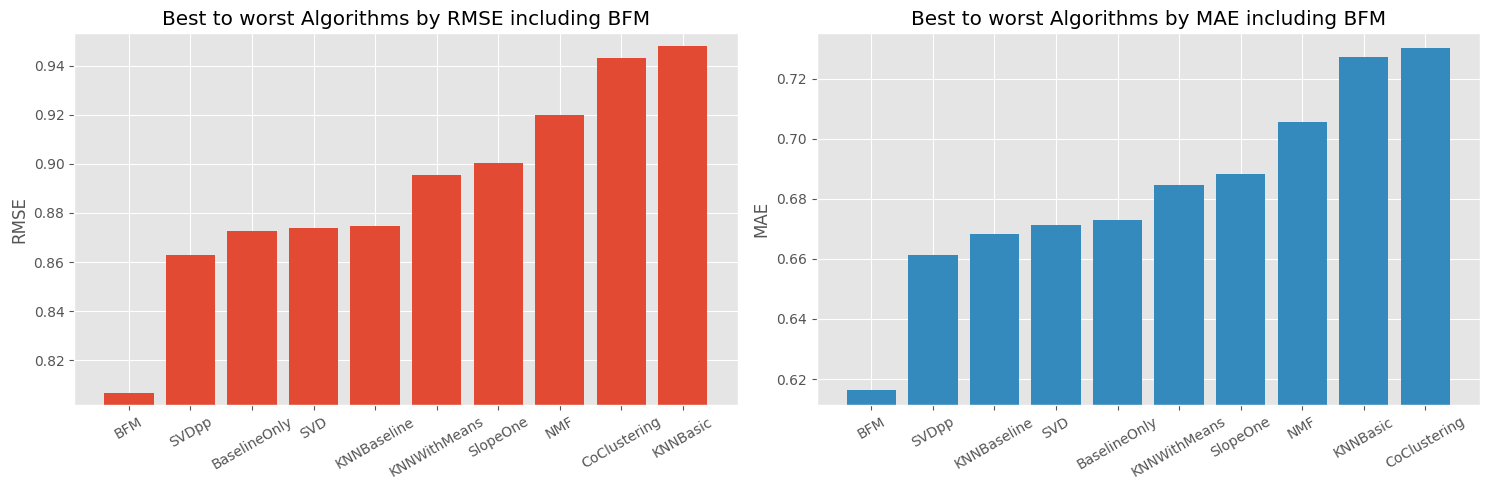

{'BaselineOnly': {'RMSE': 0.8724920183317781, 'MAE': 0.6728003991192218},
 'KNNBasic': {'RMSE': 0.9481740258445395, 'MAE': 0.7272079353654555},
 'KNNWithMeans': {'RMSE': 0.8955956496795819, 'MAE': 0.6844340646070446},
 'KNNBaseline': {'RMSE': 0.8748540091012403, 'MAE': 0.6683146170335565},
 'SVD': {'RMSE': 0.8737709758144181, 'MAE': 0.6711812673921982},
 'SVDpp': {'RMSE': 0.8627264328323765, 'MAE': 0.6611232242151358},
 'NMF': {'RMSE': 0.9200315476119151, 'MAE': 0.705533775296874},
 'SlopeOne': {'RMSE': 0.9003782381054389, 'MAE': 0.6882258082668695},
 'CoClustering': {'RMSE': 0.9430172286942792, 'MAE': 0.7300473908109396},
 'BFM': {'RMSE': 0.8067885988048065, 'MAE': 0.6163814903008937}}

In [25]:
algo_names = [
    "BaselineOnly",
    "KNNBasic",
    "KNNWithMeans",
    "KNNBaseline",
    "SVD",
    "SVDpp",
    "NMF",
    "SlopeOne",
    "CoClustering",
    "BFM",
]
rmse_scores = np.array([results[name]["RMSE"] for name in algo_names])
mae_scores = np.array([results[name]["MAE"] for name in algo_names])

# Order algorithms independently
order_rmse = np.argsort(rmse_scores)
order_mae = np.argsort(mae_scores)
# Create ordered lists for each metric
algo_names_rmse = [algo_names[i] for i in order_rmse]
algo_names_mae = [algo_names[i] for i in order_mae]

rmse_ordered = rmse_scores[order_rmse]
mae_ordered = mae_scores[order_mae]

# Create x-axis indices
x_rmse = np.arange(len(algo_names_rmse))
x_mae = np.arange(len(algo_names_mae))

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot RMSE on the left, ordered by RMSE
ax1.bar(x_rmse, rmse_ordered, color="C0")
ax1.set_title("Best to worst Algorithms by RMSE including BFM")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x_rmse)
ax1.set_xticklabels(algo_names_rmse, rotation=30)
ax1.set_ylim(rmse_ordered.min() - 0.005, rmse_ordered.max() + 0.005)

# Plot MAE on the right, ordered by MAE
ax2.bar(x_mae, mae_ordered, color="C1")
ax2.set_title("Best to worst Algorithms by MAE including BFM")
ax2.set_ylabel("MAE")
ax2.set_xticks(x_mae)
ax2.set_xticklabels(algo_names_mae, rotation=30)
ax2.set_ylim(mae_ordered.min() - 0.005, mae_ordered.max() + 0.005)

plt.tight_layout()
plt.savefig(f"{image_path}surpise_BFM_algo_comparison.png", dpi=300)
plt.show()
results